In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
def median_scale(x):
    """
    Calculating the median bandwidth parameter of the RBF kernel

    Parameters:
        - x: A tensor of shape (N, D)

    Return:
        - scale: The bandwidth of the RBF kernel using the median trick.
    """

    x_norm = (x ** 2).sum(1).view(-1, 1)
    dist = x_norm + x_norm.t() - 2.0 * torch.mm(x, x.t())
    dist = dist - torch.diag(torch.diag(dist))  # Set the diagonal element to 0
    scale = dist.view(-1).median().sqrt()

    return scale

def compute_mmd(x, y, kernel='rbf', **kwargs):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y.

    Parameters:
        - x: First set of samples. Shape: (n, d)
        - y: Second set of samples. Shape: (m, d)
        - kernel: Type of kernel to be used. Currently supports 'rbf', 'imq', 'linear', and 'cosine'.
        - **kwargs: Additional keyword arguments for the kernel functions.

    Returns:
        - mmd: The MMD value between x and y.
    """

    def rbf_kernel(x, y, bandwidth=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)
        
        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)

        return torch.exp(-distances / (2 * bandwidth * bandwidth))

    def imq_kernel(x, y, c=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)

        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)
        
        return c * c / (c * c + distances)

    def linear_kernel(x, y):
        return torch.mm(x, y.t())

    def cosine_similarity_kernel(x, y):
        x_norm = x / (x.norm(p=2, dim=1, keepdim=True) + 1e-8)
        y_norm = y / (y.norm(p=2, dim=1, keepdim=True) + 1e-8)
        return torch.mm(x_norm, y_norm.t())

    if kernel == 'rbf':
        kernel_func = rbf_kernel
    elif kernel == 'imq':
        kernel_func = imq_kernel
    elif kernel == 'linear':
        kernel_func = linear_kernel
    elif kernel == 'cosine':
        kernel_func = cosine_similarity_kernel
    else:
        raise ValueError("Unsupported kernel type.")

    with torch.no_grad():
        # Compute individual kernel matrices
        xx_kernel = kernel_func(x, x, **kwargs).mean()
        yy_kernel = kernel_func(y, y, **kwargs).mean()
        xy_kernel = kernel_func(x, y, **kwargs).mean()

    # Compute MMD
    mmd = xx_kernel + yy_kernel - 2 * xy_kernel
    return mmd


In [3]:
gs = multivariate_normal.rvs(mean=[0., 0.], cov=np.eye(2), size=10_000)

DDPG_mcmc_2D_cov_total = np.loadtxt('results/DDPG_mcmc_2D_cov.csv', delimiter=',')
DDPG_mcmc_2D_cov_burnin = DDPG_mcmc_2D_cov_total[DDPG_mcmc_2D_cov_total.shape[0] - 10_000:, :]

gs_gpu = torch.from_numpy(gs).to('cuda').half()
DDPG_mcmc_2D_cov_burnin_gpu = torch.from_numpy(DDPG_mcmc_2D_cov_burnin).to('cuda').half()

scale = median_scale(DDPG_mcmc_2D_cov_burnin_gpu)

DDPG_mcmc_MMD = []

In [4]:
for i in [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]:
    DDPG_mmd_value = compute_mmd(gs_gpu[0:i], DDPG_mcmc_2D_cov_burnin_gpu[0:i], kernel='rbf', bandwidth=scale)
    DDPG_mcmc_MMD.append(DDPG_mmd_value)
    del DDPG_mmd_value



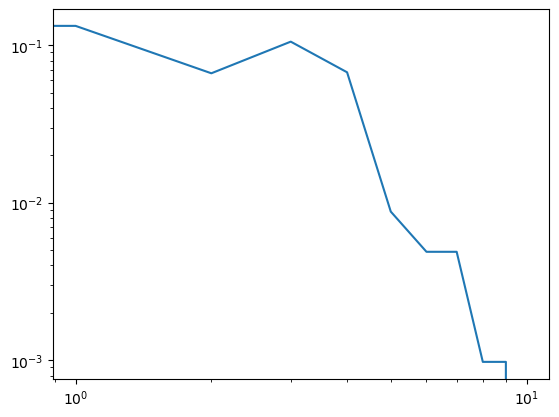

In [5]:
plt.loglog([i.to('cpu').numpy() for i in MMD_res])